## Super-Resolution Image Generation Class

The purpose of this notebook is to develop a class which can be consistently use for image handling when working with Super-Resolution (SR) models (mainly on MRI or other 3D medical images). Since the problem that Super-Resolution models are aiming to solve is fairly consistent, there should be significant overlap in how testing and training images are created/handled.


### DISCLAIMER:
This class is meant to make playing around with SR models easier on *personal* computing hardware. This class is not designed with large computing resources in mind and will likely be less efficient than other methods. There are three particular issues related to playing around with SR that this class is meant to address:
1. **Overhead involved with augmentation of training and testing images**. When bug-testing and playing around with hyperparameters, the overhead of augmentating images, taking patches, etc. add time that isn't necessary. By generating these images/sub-images ahead of time the local memeory is leveraged to skip these steps each time you re-run after changing something. Once everything is working, it's easy to keep generating new augmented images as the model is trained.

2. **RAM limitations on personal devices**. Medical/3D images can be painfuly large. If you are training a model on sub-samples/patches of larger files, you either have to only sample from a subset of images for a batch, then load another subset for the next batch (hindering how randomly sampled the contents of each batch are), or inefficiently load images randomly only to take 1-2 sub-samples/patches from them. By saving these sub-samples/patches as seperate files ahead of time, random sampling is easier and less demanding of resources.

3. **Data organization**. It is very easy to get turned around when generating the low-resolution and high-resolution image pairs for training and testing. This class enforces a consistent organizational method, which allows it to take inventory and find matching images from previously generated images.


### Functionality:
To prevent this class from becoming a bloated mess of functionality and niche features, the ideal capabilities of this class will be cataloged here. The goals for this tool are:
1. Given an input directory, list all files that match a particular `prefix` and `suffix`
    - Detect if the directory(s) given were generated by this class previously
2. Load common image types:
    [X] `.png`
    [] `.nii` and `.nii.gz`
    [] `.dcm`
3. Support several different methods of downsampling and upsampling:
    [] bilinear interpolation
    [] trilinear interpolation
    [] "nearest" (see pytorch torchvision)
4. Create randomly shuffled/altered images at different resolutions (gaussian blur, affine transformation, etc.)
    - Make the aspect of saving these images optional so it can be used as a `generator` if possible
5. Display sample images from the generated images for assurance when prompted
6. Save files in multiple formats, when relevant:
    - 2D full image (potentially transformed)
    - 2D patch
    - 3D full image (potentially transformed)
    - 3D "patch", or a sub-volume for the 
7. Save any image generated in a specified format
8. Have locations of matching low and high resolution images
9. Generate file containing the values used in the template for future revisting.

## Import necessary libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import shutil
import numpy as np
from PIL import Image
import random
import cv2
from matplotlib import pyplot
from skimage.transform import rotate, AffineTransform, warp, rescale

## Class definition

In [ ]:
# The super resolution class:

class sr_gen():
    def __init__(self, inp_dir, HR_out_dir, LR_out_dir, prefix='', suffix=''):
        self.inp_dir = inp_dir
        self.HR_out_dir = HR_out_dir
        self.HR_files = None
        self.LR_out_dir = LR_out_dir
        self.LR_files = None
        self.inp_files = self._get_inp_(prefix, suffix)
        self.template = self.get_template()

    def _get_inp_(self, prefix='', suffix=''):
        # Get the original files that will be used to generate everything
        # Based on the prefix, for now this could be nifti files or png's.
        # Will have to write a "try" statement in order to check for file type
        files = []
        for fil in os.listdir(self.inp_dir):
            if fil.startswith(prefix) & fil.endswith(suffix):
                files.append(fil)
        
        if not files:
            raise FileNotFoundError('No applicable files found in input directory')

        return files

    def _get_LR_out_(self):
        # get list of files in output directory and determine matching files
        return os.listdir(self.LR_out_dir)

    def _get_HR_out_(self):
        return os.listdir(self.HR_out_dir)


    def _view_sample_(self):
        # Function which loads and displays random example image for sanity check
        pyplot.figure()
        f, axes = pyplot.subplots(2,2)
        
        indx = random.randint(0,len(self.inp_files)-1)
        indy = random.randint(0,len(self.HR_files)-1)

        axes[0,0].imshow(np.array(Image.open(self.inp_dir+self.inp_files[indx])))
        axes[1,0].imshow(np.array(Image.open(self.HR_files[indy])))
        axes[1,1].imshow(np.array(Image.open(self.LR_files[indy])))


    def get_template(self):
        # Returns dictonary of all option settings for this class
        try:
            return self.template
        except:
            return {'out_type':'png', # png, nii (?), DICOM (?)
                    'unit':'intensity', #Whether you want RBG or Intensity/DICOM units
                    'resolution':2,
                    'translation_x':10,
                    'translation_y':10,
                    'rotation':0,
                    'scale':2,
                    'patch':False,
                    'step': 10,
                    'keep_blank':False,
                    }

    def save_template(self, temp):
        # apply the provided template for randomization to self for access by other functions
        self.template = temp


    def run(self, clear=False):
        # Run the analysis specified in the template dictionary. If clear is true then the 
        # files in the output directories will be deleted before creating the new images.

        if clear:
            print('Clearing existing output directories')
            shutil.rmtree(self.HR_out_dir, ignore_errors=True)
            shutil.rmtree(self.LR_out_dir, ignore_errors=True)

        # Make the directories where the new files will be saved
        os.makedirs(self.HR_out_dir, exist_ok=True)
        os.makedirs(self.LR_out_dir, exist_ok=True)

        HR_out_files = []
        LR_out_files = []
        
        s = 1/self.template['resolution']
        for im in self.inp_files:
            im_h = np.array(Image.open(self.inp_dir + im))

            # check the dimensions of the image
            #print(f'Shape of High Resolution Image:{im_h.shape}')

            im_h = self.rgb2ycrbcr(im_h)
            im_h = im_h[:,:,0] #Just deal with intensity values at the moment because 
                                # having multiple channels throws off cv2 when saving, 
                                # since it also does BGR instead of RGB and will save a blue image

            # TODO: compare cv2.resize with skimage.rescale or pytorch rescale for this
            im_l = cv2.resize(im_h, (0,0), fx = s, fy =s, interpolation=cv2.INTER_CUBIC)
            im_l = cv2.resize(im_l, (0,0), fx = self.template['resolution'],
            fy=self.template['resolution'], interpolation=cv2.INTER_CUBIC)
            # TODO: The above resizing results in values outside of the range [0, 255] due to 
            # the INTER_CUBIC method. For now I'm just clipping the values, but a more nuanced
            # answer should be found
            im_l = np.clip(im_l, 0, 255)

            if self.template['patch']:
                im, im_h, im_l = self.img_transform(im, im_h, im_l)
                _ = self.img2patches(im, im_h, im_l, keep_blank = self.template['keep_blank'],save=True)
                HR_out_files = HR_out_files + _

            else:
                _ = self.img_transform(im, im_h, im_l, save=True)
                HR_out_files.append(_)
        
        #Do LR first because otherwise HR_out_files is changed
        LR_out_files = [self.LR_out_dir + s for s in HR_out_files]
        HR_out_files = [self.HR_out_dir + s for s in HR_out_files]

        self.HR_files = HR_out_files
        self.LR_files = LR_out_files


    def img_transform(self,im, im_h, im_l, save=False):
        # Transform the original files using a variety of methods

        opp = '' #string for storing the operations performed on the images

        # If shifting in the x or y direction was selected
        if self.template['translation_x'] > 0 | self.template['translation_y'] > 0:
            _a = np.random.randint(0,self.template['translation_x'])
            _b = np.random.randint(0,self.template['translation_y'])
            transform = AffineTransform(translation=(_a, _b))
            im_h = warp(im_h, transform,mode='reflect')
            im_l = warp(im_l, transform,mode='reflect')
            opp += f'_x{_a}_y{_b}'

        if self.template['scale'] > 1:
            _a = np.random.randint(1,self.template['scale']+1)
            #transform = AffineTransform(scale=_a)
            im_h = rescale(im_h, scale = _a, mode='reflect')
            im_l = rescale(im_l, scale = _a, mode='reflect')
            opp+= f'_scale{_a}'

        # If rotation was selected
        if self.template['rotation'] > 0:
            _a = np.random.randint(-self.template['rotation'],self.template['rotation'])
            im_h = rotate(im_h, _a, mode="reflect")
            im_l = rotate(im_l, _a, mode="reflect")
            opp+= f'_rot{_a}'

        opp = im.split('.')[0] + opp

        if save:
            print(f'Saving image: {opp}')
            cv2.imwrite(f'{self.HR_out_dir}/{opp}.png', im_h)
            cv2.imwrite(f'{self.LR_out_dir}/{opp}.png', im_l)
            return opp
        else:
            return opp, im_h, im_l

    def img2patches(self, im, im_h, im_l=False, keep_blank=False, save=False):
        # Take a given image and generate patches and returns a stack of images
        # im : str, name of the image being cut into patches
        # im_h : ndarray, numpy array of the high-resolution image
        # im_l : ndarray, numpy array of the low-resolution image. If this is false, 
        # then you only want to make patches from one image (in this case im_h)

        patch_size = self.template['patch']
        step = self.template['step']


        # Get the height and width of the provided images
        h_h, w_h = im_h.shape
        h_l, w_l = im_l.shape

        # Create a numpy stack following Pytorch protocols
        HR_stack = np.zeros((len(range(0,w_h,step))*len(range(0,h_h,step)),patch_size,patch_size))
        if isinstance(im_l, np.ndarray):
            LR_stack = np.zeros((len(range(0,w_h,step))*len(range(0,h_h,step)),patch_size,patch_size))

        im_name = im.split('.')[0]

        cnt = 0
        blank = 0

        for i in range(0,w_h,step):
            for j in range(0,h_h,step):
                if i+patch_size < w_h and j+patch_size < h_h:

                    sample_h = im_h[j:j+patch_size, i: i+patch_size]
                    if isinstance(im_l, np.ndarray):
                        sample_l = im_l[j:j+patch_size, i:i+patch_size]

                    # if you've chosen to keep blank patches or if the patch is not blank add 
                    # it to the stack
                    if keep_blank or (sample_h.max() > 0 or sample_l.max() > 0):
                        HR_stack[cnt, :,:] = sample_h
                        if isinstance(im_l, np.ndarray):
                            LR_stack[cnt,:,:] = sample_l
                        cnt += 1
                    else:
                        blank += 1



        # Return a list of image names and numpy array with the first cnt layers
        HR_fnames = []
        for i in range(cnt):
            HR_fnames.append(f'{im_name}_{i}.png')

        if save: #Whether to save a patch if it is blank/intensity value of 0
            for i in range(cnt):
                cv2.imwrite(f'{self.HR_out_dir}/{im_name}_{i}.png', HR_stack[i,:,:])
                if isinstance(im_l, np.ndarray):
                    cv2.imwrite(f'{self.LR_out_dir}/{im_name}_{i}.png', LR_stack[i,:,:])
            return HR_fnames
        
        else:
            if isinstance(im_l, np.ndarray):
                return HR_fnames, HR_stack[:cnt,:,:], LR_stack[:cnt,:,:]
            else:
                return HR_fnames, HR_stack[:cnt,:,:]
        


    def rgb2ycrbcr(self, img_rgb):
        # Takes an RBG image and returns it as a YCRBCR image (if you just want to focus
        #  on luminance values of an image)

        img_rgb = img_rgb.astype(np.float32)

        img_ycrcb = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YCR_CB)
        img_ycbcr = img_ycrcb[:,:,(0,2,1)].astype(np.float32)
        img_ycbcr[:,:,0] = (img_ycbcr[:,:,0]*(235-16)+16)/255.0
        img_ycbcr[:,:,1:] = (img_ycbcr[:,:,1:]*(240-16)+16)/255.0

        return img_ycbcr


    def load_image_pair(self, im_id):
        # A method which loads the provided file and returns a numpy array
        # this is used because it will remember in the template dictionary how
        # the images were saved (either as RBG or intensity values or 3D array). 
        # This will help minimize headaches caused by different image types.

        # im_id can either be the index value or the name of the file
        if isinstance(im_id, int):
            HR_file = self.HR_files[im_id]
            LR_file = self.LR_files[im_id]
        elif isinstance(im_id, str):
             _ = self.HR_files.index(im_id)
             HR_file = self.HR_files[_]
             LR_file = self.LR_files[_]
        else:
            TypeError("Invalid image identifier, please input a string to integer")

        # Check what data type to load from the template
        if self.template['out_type'] == 'png':
            im_h = np.array(Image.open(HR_file))
            im_l = np.array(Image.open(LR_file))


        return im_h, im_l

    def match_altered(self, update=True, paths=False):
        # Get the files that have been generated in the output directory
        # If update is false, then just return a list of matched names, if true then
        # change the class variable values accordingly.
        hr_files = self._get_HR_out_()
        lr_files = self._get_LR_out_()

        # Get a set of all the files with agreement before the metadata
        if len(hr_files) > len(lr_files):
            matches = list(set(hr_files)-(set(hr_files)-set(lr_files)))
        else:
            matches = list(set(lr_files)-(set(lr_files)-set(hr_files)))

        if update:
            # If you want to save these matched files as class variables
            self.HR_files = [self.HR_out_dir + _ for _ in matches]
            self.LR_files = [self.LR_out_dir + _ for _ in matches]
            print('HR and LR file locations updated')
        
        if paths:
            return self.HR_files, self.LR_files

    def change_out(self, HR_out_dir, LR_out_dir):
        # Change the output locations so you can save into a new file
        self.HR_out_dir = HR_out_dir
        self.HR_files = None
        self.LR_out_dir = LR_out_dir
        self.LR_files = None

In [ ]:
qq = sr_gen('./data/raw/nii_sub_HR/','./data/raw/HR_output/','./data/raw/LR_output/')

In [ ]:
#qq.match_altered(True)
#pyplot.imshow(qq.load_image_pair(4)[1])

In [ ]:
temp = qq.get_template()
temp["patch"]=20
temp["step"]=60
qq.save_template(temp)

In [ ]:
qq.run(clear=True)

In [ ]:
qq.match_altered(update=True)
qq._view_sample_()

In [ ]:
grayim = np.zeros(im_h.shape)
grayim[:,:,0]= grayim[:,:,1] = grayim[:,:,2] = im_h[:,:,0]

cv2.imwrite('test.png',grayim[:,:,0])

In [ ]:
np.array(Image.open('./test.png')).shape

## Experimentation with Nifti loading and saving

In [3]:
import nibabel as nib
# https://nipy.org/nibabel/gettingstarted.html

#nibabel load gets the shape and data type without needing to load anything. To do that you need to call get_fdata()
img = nib.load('../data/nifti/MPRAGE_Structural_Scan.nii')

In [4]:
#Get information from the header of img
img.header.get_xyzt_units()

('mm', 'sec')

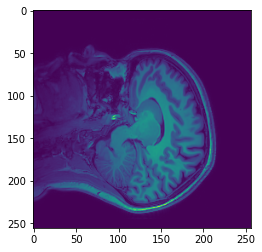

In [5]:
from matplotlib import pyplot
data = img.get_fdata()

# dimensions are [coronal,axial,sagittal]
pyplot.imshow(data[:,:,90])
pyplot.show()

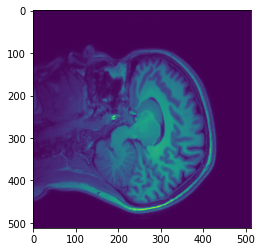

In [6]:
# Apply transformations to the data
_ = rescale(data, scale=(2,2,2), mode='reflect')
pyplot.imshow(_[:,:,180])
pyplot.show()

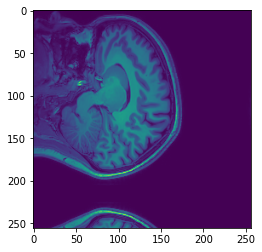

In [7]:
# Translation

#okay, for some reason, scikitimage does not work with 3D as intended, but will accept it for some reason....
trans = np.eye(3)
trans[:2,2]=40 #move 40 in the coronal and axial directions (i think?)
transform = AffineTransform(matrix = trans)
_ = warp(data, transform, mode = 'reflect')
pyplot.imshow(_[:,:,90])
pyplot.show()

In [8]:
#Going to need to normalize the nifti data into some consistent range...
_.max()

613182.6304931641

In [ ]:
data.shape

In [ ]:
#rotation
samp_dat = np.array([[[1,2,3],[4,5,6]],[[7,8,9],[10,11,12]]])
#im_h = rotate(im_h, _a, mode="reflect")
rotate(samp_dat,angle=0)

In [ ]:
# Try to do rotation in another way
from math import sin, cos, radians
trans = np.eye(3)
theta = radians(20)
trans[0,0]=cos(theta)
trans[0,1]=-sin(theta)
trans[1,0]=sin(theta)
trans[1,1]=cos(theta)

#For just rotation along the sagittal plane with no scaling:
# [cos(), -sin(), 0]
# [sin(), cos(), 0]
# [0, 0, 1]

transform = AffineTransform(matrix = trans)
_ = warp(data, transform, mode = 'reflect')
pyplot.imshow(_[:,:,90])
pyplot.show()

In [ ]:
# Save selection of nifty file as its own nifti file
qq = nib.Nifti1Image(data[:,:,90], np.eye(4))
nib.save(qq, './practice_nifti.nii.gz')

In [ ]:
img = nib.load('./practice_nifti.nii.gz') #test loading of nii.gz files
data = img.get_fdata()
pyplot.imshow(data)
pyplot.show()

## Experimentation with DICOM loading and saving

In [1]:
import pydicom as dicom

In [43]:
# Load single dicom image
ds = dicom.dcmread('../data/dicom/A0009')
(2,) + ds.pixel_array.shape


(2, 256, 256)

In [65]:
# Load stack of .dcm images
image_path = '../data/dicom/'

im_list = sorted(os.listdir(image_path)) #SORTING IS VERY IMPORTANT FOR 3D IMAGES IN DICOM

In [72]:
stk = np.zeros((len(im_list),)+dicom.dcmread(image_path+im_list[0]).pixel_array.shape) # weird thing I have to do to make (h,w) into (s, h, w) because you can add to tuples 
for idx, f in enumerate(im_list):
    #print(f)
    stk[idx,:,:] = dicom.dcmread(image_path + f).pixel_array

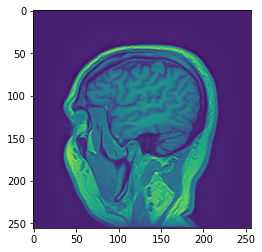

In [71]:
pyplot.imshow(stk[41,:,:])

## Test with Dataloader and NN model
Here we'll make sure the above class works in a way that is compatible with Pytorch's Dataloader and ML modeling

In [ ]:
# TODO: There's not reasing I can't combine the Dataset class and my custom class into one thing

class Dataset(torch.utils.data.Dataset):
    def __init__(self, sr_class):
        self.sr_class = sr_class

        # In case I forget to run match_altered before pulling the class
        if not sr_class.HR_files:
            sr_class.match_altered(update=True)

    def __len__(self):
        return len(self.sr_class.HR_files)

    def __getitem__(self, index):
        Y, X = self.sr_class.load_image_pair(index)
        X = torch.unsqueeze(torch.tensor(X, dtype=torch.float32),0)
        Y = torch.unsqueeze(torch.tensor(Y, dtype=torch.float32),0)

        return X, Y

In [ ]:
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 0}

training_set = Dataset(qq)
training_generator = torch.utils.data.DataLoader(training_set, **params)

In [ ]:
class SCN(nn.Module):
    def __init__(self,sy,sg, model_file=False, train=True):
        super().__init__()
        C = 5
        L = 5

        Dx = torch.normal(0,1, size = (25,128))
        Dy = torch.normal(0,1, size = (100,128))
        I = torch.eye(128)

        self.conv = nn.Conv2d(1,100,9, bias = False, stride =1, padding = 6)
        self.mean2 = nn.Conv2d(1,1,13, bias = False, stride = 1, padding = 6)
        self.diffms = nn.Conv2d(1,25,9, bias=False, stride = 1, padding=6)

        self.wd = nn.Conv2d(100,128,1,bias = False, stride = 1)
        self.usd1 = nn.Conv2d(128, 128, 1, bias = False, stride=1)
        self.ud = nn.Conv2d(128,25,1,bias=False,stride=1)
        self.addp = nn.Conv2d(16,1,1, bias = False, stride = 1)

        if train: #If you are currently training the model
            self.mean2.weight = torch.nn.Parameter(self.create_gaus(13), requires_grad = False)
            self.diffms.weight = torch.nn.Parameter(self.create_diffms(9,5),requires_grad=False)
            self.wd.weight = torch.nn.Parameter(self.expand_params(C*Dy.T), requires_grad=True)
            self.usd1.weight = torch.nn.Parameter(self.expand_params(I - torch.matmul(Dy.T,Dy)), requires_grad=True)
            self.ud.weight = torch.nn.Parameter(self.expand_params((1/(C*L))*Dx), requires_grad=True)
            self.addp.weight = torch.nn.Parameter(torch.ones(1,16,1,1)*0.06, requires_grad=True)

        else:
            self.conv.weight = torch.nn.Parameter(torch.ones(100,1,9,9),requires_grad=False)
            self.mean2.weight = torch.nn.Parameter(self.create_gaus(13),requires_grad=False)
            self.diffms.weight = torch.nn.Parameter(self.create_diffms(9,5),requires_grad=False)
            self.wd.weight = torch.nn.Parameter(self.expand_params(C*Dy.T),requires_grad=False)
            self.usd1.weight = torch.nn.Parameter(self.expand_params(I - torch.matmul(Dy.T,Dy)),requires_grad=False)
            self.ud.weight = torch.nn.Parameter(self.expand_params((1/(C*L))*Dx),requires_grad=False)
            self.addp.weight = torch.nn.Parameter(torch.ones(1,16,1,1)*0.06,requires_grad=False)


    def forward(self, x, k, sy=9, sg=5):
        im_mean = self.mean2(x)
        # print(f'im_mean shape {im_mean.shape}')
        diffms = self.diffms(x)
        # print(f'diffms shape: {diffms.shape}')

        n, c, h, w = x.shape
        # y = torch.zeros(n, 100, h-8, w-8)
        x = self.conv(x)
        # print(f'post conv shape {x.shape}')
        #print(f'conv max {x.max()}')
        x=x+1

        x = x/torch.linalg.vector_norm(x, ord=2, dim=1, keepdim=True)
        # print(f'post vector norm shape: {x.shape}')
        #print(f'postnorm max {x.max()}')

        x = self.wd(x)
        #print(f'conv wd {x.max()}')
        z = self.ShLU(x,1)
        #print(f'conv SHLU {x.max()}')

        # Go through LISTA
        for i in range(k):
            z = self.ShLU(self.usd1(z)+x,1)

        x = self.ud(z)
        #print(f'ud max {x.max()}')
        # print(f'post ud shape {x.shape}')
        x = (x/torch.linalg.vector_norm(x, ord=2, dim=1, keepdim=True))*torch.linalg.vector_norm(diffms, ord=2, dim=1, keepdim=True)*1.1
        # print(f'prereassembled x shape {x.shape}')
        x = self.reassemble2(x,im_mean,4)
        # print(f'reassembled x shape {x.shape}')
        x = self.addp(x)
        #print(f'x.reassemble.max = {x.max()}')
        x = x+im_mean

        return x

    def reassemble2(self, x, im_mean, patch_size):
        img = im_mean
        s, c, h, w = img.shape
        
        # img_stack=torch.zeros(s,25,h,w)
        img_stack=torch.zeros(s,16,h,w)
        
        #go through every sample and reassemble the image
        for q in range(x.shape[0]):
            filt = 0
            for ii in range(patch_size-1, -1, -1):
                for jj in range(patch_size-1, -1, -1):
                    img_stack[q,filt,:,:] = x[q,filt,jj:(jj+h), ii:(ii+w)]
                    filt+=1
        
        return img_stack
    
    def create_diffms(self, kern_size, sy=5):
        diffms = torch.zeros(sy**2,1,kern_size,kern_size)
        
        neg = -1*(1/(sy**2))
        pos = 1+neg
        
        border = int((kern_size-sy)/2)
        base = torch.zeros(sy,sy)+neg
        cnt=0
        
        for i in range(sy**2):
            base = torch.zeros(sy**2)+neg
            base[cnt]=pos
            diffms[i,0,border:(kern_size-border),border:(kern_size-border)] = base.reshape([sy,sy])
            cnt+=1
        return diffms
    
    
    def create_gaus(self, kern_size, sy=9,std=2.15):
        n = torch.arange(0,sy)-(sy-1.0)/2.0
        sig2 = 2 * std * std
        gkern1d = torch.exp(-n ** 2 / sig2)
        gkern1d = gkern1d/torch.sum(gkern1d)
        #print(gkern1d.shape)
        gkern2d = torch.outer(gkern1d, gkern1d)
    

        # Wrap in zeros, if kern_size > sy
        gaussian_filter = torch.zeros(1,1,kern_size,kern_size)
        border = int((kern_size-sy)/2)
        gaussian_filter[0,0,border:(kern_size-border),border:(kern_size-border)] = gkern2d#(sy,std=std)
        #print(gaussian_filter.shape)
        return gaussian_filter
        
    
    def fixed_positions(self, tens, mult, sg):
        f, _ , h, w = tens.shape
        new_filt = torch.zeros(f*mult, 1, sg,sg)
        cnt = 0
        filt = 0
        
        for filt in range(f):
            for j in range((sg-w)+1):
                for i in range((sg-h)+1):
                    new_filt[cnt,0,i:i+h,j:j+w] = tens[filt]
                    cnt+=1
        return new_filt
    
    def expand_params(self,tens):
        return torch.unsqueeze(torch.unsqueeze(tens,2),3)
    
    def ShLU(self,a, th):
        return torch.sign(a)*torch.maximum(abs(a)-th, torch.tensor(0))

## Set Optimization Parameters

In [ ]:
net = SCN(9,5,train=True)
criterion = nn.MSELoss()

optimizer = optim.SGD(
    [
        {"params": net.addp.parameters()},#, "lr": 0.0002, "momentum": 0.00005},
        {"params": net.conv.parameters()},#, "lr": 0.0003, "momentum": 0.0001},
        {"params": net.wd.parameters()},
        {"params": net.usd1.parameters()},
        {"params": net.ud.parameters()},
    ],
    lr=0.00007, momentum = 0.0001
)

## Training Loop

In [ ]:
from tqdm import tqdm
import time
# Loop over epochs

max_epochs = 20

for epoch in tqdm(range(max_epochs)):
    losses = []
    losses_per = []

    # Training
    count = 0
    for inp, goal in training_generator:
        optimizer.zero_grad()

        output = net(inp,2) # the 2 is the number of iterations in the LISTA network
        print(output.shape)
        output = torch.clamp(output, 0, 255)

        loss = criterion(output,goal)
        loss.backward()
        optimizer.step()
        print(f'loss = {loss.item()}')
        losses.append(loss.item())
        print(f'mini-batch # {count}, mean loss = {sum(losses)/len(losses)}')
        count = count+1

    torch.save(net.state_dict(), f'./MRI_save_{epoch}.p')
    print(f'\n\n epoch {epoch}, loss mean: {sum(losses)/len(losses)}, loss: {min(losses)}-{max(losses)}\n')

    # Give computer time to cool down
    time.sleep(10)

## Testing Loop